In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os

from models.ecoli.analysis import parcaAnalysisPlot
from wholecell.analysis.analysis_tools import exportFigure
from wholecell.utils import constants
from wholecell.utils import units

In [101]:
NE_path ='/Users/noravivancogonzalez/Desktop/CLNE_files/CLNE_NE_rates_only.xlsx'
NE_rates_df = pd.read_excel(NE_path)
CL_path ='/Users/noravivancogonzalez/Desktop/CLNE_files/CLNE_CL_rates_only.xlsx'
CL_rates_df = pd.read_excel(CL_path)

# NE_path ='~/wcEcoli/models/ecoli/analysis/local_notebooks/C_limited_PDR_analyses_with_published_paper_data/previous_models/CLNE_files/CLNE_NE_rates_only.csv'
# NE_rates_df = pd.read_csv(NE_path)
# CL_path ='~/wcEcoli/models/ecoli/analysis/local_notebooks/C_limited_PDR_analyses_with_published_paper_data/previous_models/CLNE_files/CLNE_CL_rates_only.csv'
# CL_rates_df = pd.read_csv(CL_path)

In [102]:
s1_path ='/Users/noravivancogonzalez/Desktop/Gupta2024_TableS1.xlsx'
table_s1_df = pd.read_excel(s1_path, skiprows=[0, 1, 2, 3])
df = pd.read_excel(s1_path, nrows=2, skiprows=[0, 1, 2], header = None)
media_condition_dict = dict(zip(df.iloc[1], df.iloc[0]))
clim_df = table_s1_df[['Protein ID', 'Gene names ', 'C-lim3_1', 'C-lim3_2',
       'C-lim6_1', 'C-lim6_2','C-lim12_1','C-lim12_2']] # exclude provided means because we will drop the "celing values"
# Create a deep copy
full_clim_values_df= clim_df.copy(deep=True)

In [103]:
clim_df[clim_df['Gene names '].isnull()]

,Protein ID,Gene names,C-lim3_1,C-lim3_2,C-lim6_1,C-lim6_2,C-lim12_1,C-lim12_2
152,sp|P07363-2|CHEA_ECOLI,NaN,1.213432,1.21305,NaN,NaN,NaN,NaN
1968,sp|P63284-2|CLPB_ECOLI,NaN,NaN,NaN,8.000*,5.256166,10.584218,11.17575


In [104]:
clim_df.drop(columns = ['Gene names '], inplace = True)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/2934582321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df.drop(columns = ['Gene names '], inplace = True)


In [105]:
#only dropping row if all clim columns are nan
clim_df.dropna(subset = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
               how = 'all', inplace = True)
clim_df.reset_index(drop = True, inplace = True)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/4193110357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df.dropna(subset = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],


In [106]:
#will exclude "ceiling/undetermined values" marked by *
clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(str)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/2391266706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(str)


In [107]:
clim_df = clim_df.applymap(lambda x: None if x.endswith('*') else x)

In [108]:
clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(float)

In [109]:
#only dropping row if all clim columns are nan, now that * values have been switched to NaN
clim_df.dropna(subset = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
               how = 'all', inplace = True)
clim_df.reset_index(drop = True, inplace = True)

In [110]:
clim_df.set_index(['Protein ID'], inplace = True)

In [112]:
def find_max_column_custom(row):
    max_value = row.max()
    max_column = row[row == max_value].index[0]
    return max_column

clim_df['max_column'] = clim_df.apply(find_max_column_custom, axis=1)

In [113]:
# Find which proteins did NOT have their max half life in the 12 hr doubling time clim
non_12_mask = (clim_df['max_column'] != 'C-lim12_1') &(clim_df['max_column'] != 'C-lim12_2')
non_12_list = clim_df[non_12_mask].index

In [114]:
list_12 = clim_df[~non_12_mask].index

In [115]:
def calculate_difference(row):
    """Calculates the absolute difference between two values based on the 'max_column', handling NaN values."""

    columns = {'C-lim12': ('C-lim12_1', 'C-lim12_2'),
               'C-lim6': ('C-lim6_1', 'C-lim6_2'),
               'C-lim3': ('C-lim3_1', 'C-lim3_2')}

    for col, (col1, col2) in columns.items():
        if col in row['max_column']:
            return abs(row[col1] - row[col2]) if not np.isnan(row[col1]) and not np.isnan(row[col2]) else np.nan

    return np.nan

In [116]:
clim_df['difference'] = clim_df.apply(calculate_difference, axis=1)

In [117]:
clim_df['notes'] = None

In [118]:
# Keep assignment of max_column if replicates at the chosen doubling time column have a difference less than or equal to 3 hrs
clim_df['notes'][clim_df['difference'] <= 3] = 'consistent'

#262 assigned values have a difference greater than 3 hrs between replicates at the chosen doubling time column
#definitely assign to a value >6, but should it be the mean?
clim_df['notes'][(clim_df['difference']>3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) & (clim_df['C-lim12_2'] > 6))] = '> 6 hrs, inconsistent'

#assign...clim6 value if both replicates are present? Because clim12 value might be outlier/inconsistent
clim_df['notes'][(clim_df['difference']>3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, inconsistent'

#unsure what to assign, mean? This indicates inconsistent values 
clim_df['notes'][(clim_df['difference']>3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, inconsistent'


#300 assigned large values one have 1 replicate in that doubling time column

clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 6 hrs, 1 replicate'
#unsure what to assign...clim6 value if both replicates are present? Because clim12 value might be outlier/inconsistent
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
         & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, 1 replicate'
#unsure what to assign...clim6 or clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) & (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, 1 replicate'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? 
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))
        & ((clim_df['C-lim3_1'] > 0) & (clim_df['C-lim3_2'] > 0))] = '> 3 hrs, 1 replicate'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))
        & ((clim_df['C-lim3_1'] > 0) & (clim_df['C-lim3_2'] > 0))] = '< 3 hrs, 1 replicate'
#unsure what to assign... Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim3') 
        & ((clim_df['C-lim3_1'] > 0) | (clim_df['C-lim3_2'] > 0))] = '< 3 hrs, 1 replicate'

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/1453389500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['difference'] <= 3] = 'consistent'
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/1453389500.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][(clim_df['difference']>3)
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/1453389500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [119]:
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))] = '< 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))] = '> 3 hrs, inconsistent'
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))
       ] = '> 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = 'inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))] = '> 3hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))]= '> 3, inconsistent'

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/208143188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['notes'].isna()
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/208143188.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['notes'].isna()
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/208143188.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [120]:
clim_df['notes'] = clim_df['notes'].str.replace('> 3hrs, inconsistent', '> 3 hrs, inconsistent')

In [121]:
clim_df['notes'].unique()

array(['consistent', None, '> 6 hrs, 1 replicate',
       '> 3 hrs, inconsistent', '> 6 hrs, inconsistent',
       '> 3, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent'],
      dtype=object)

In [122]:
#use a dictionary to assign which values to use for the ultimate protein half life
# I will use the median of all available values beyond specified threshold for values that have only 1 replicate or are inconsistent

threshold_dict = {
    'consistent': None, 
    '> 6 hrs, 1 replicate': '> 6', 
    '> 3 hrs, inconsistent': '> 3',
    '> 6 hrs, inconsistent': '> 6', 
    '< 3 hrs, inconsistent': '< 3',
    '> 3 hrs, 1 replicate': '> 3',
    '< 3 hrs, 1 replicate': '< 3',
    'inconsistent': '> 0' }

In [123]:
clim_df['threshold_expr'] = clim_df['notes'].map(threshold_dict)

In [124]:
clim_df.reset_index(inplace = True)

In [125]:
clim_df.columns

Index(['Protein ID', 'C-lim3_1', 'C-lim3_2', 'C-lim6_1', 'C-lim6_2',
       'C-lim12_1', 'C-lim12_2', 'max_column', 'difference', 'notes',
       'threshold_expr'],
      dtype='object')

In [126]:
clim_df.columns[6:]

Index(['C-lim12_2', 'max_column', 'difference', 'notes', 'threshold_expr'], dtype='object')

In [130]:
clim_long = clim_df[clim_df['notes'] != 'consistent'].melt(id_vars = ['Protein ID','notes', 'threshold_expr'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)').dropna()

In [131]:
clim_long

,Protein ID,notes,threshold_expr,replicate name,half life (hrs)
1,sp|P00490|PHSM_ECOLI,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.244616
2,sp|P00634|PPB_ECOLI,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.196812
3,sp|P00803|LEP_ECOLI,"> 3 hrs, inconsistent",> 3,C-lim3_1,3.629282
4,sp|P00903|PABA_ECOLI,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.273867
5,sp|P00954|SYW_ECOLI,"> 6 hrs, inconsistent",> 6,C-lim3_1,2.860747
...,...,...,...,...,...
5556,sp|P42630|TDCG_ECOLI,"< 3 hrs, inconsistent",< 3,C-lim12_2,2.339733
5559,sp|P77316|YBDR_ECOLI,inconsistent,> 0,C-lim12_2,10.210846
5560,sp|Q46901|CSE1_ECOLI,"> 3 hrs, inconsistent",> 3,C-lim12_2,6.234971
5567,sp|P30131|HYPF_ECOLI,"> 6 hrs, inconsistent",> 6,C-lim12_2,8.033393


In [132]:
clim_long['notes'].unique()

array(['> 6 hrs, 1 replicate', '> 3 hrs, inconsistent',
       '> 6 hrs, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent'],
      dtype=object)

In [133]:
#if threshold above 6 then make half life <=6 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='> 6') &(clim_long['half life (hrs)'] <= 6)]= np.nan
#if threshold above 3 then make half life <=3 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='> 3') &(clim_long['half life (hrs)'] <= 3)]= np.nan
#if threshold below 3 then make half life >=3 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='< 3') &(clim_long['half life (hrs)'] >= 3)]= np.nan

In [134]:
clim_long.dropna(inplace = True)

In [135]:
clim_long.columns

Index(['Protein ID', 'notes', 'threshold_expr', 'replicate name',
       'half life (hrs)'],
      dtype='object')

In [136]:
#if half life is not consistent, choose the median among available values per category in Protein ID
inconsistent_protein_medians = clim_long.groupby(['Protein ID','notes',
       'threshold_expr' ])['half life (hrs)'].median().reset_index()

In [137]:
inconsistent_protein_medians

,Protein ID,notes,threshold_expr,half life (hrs)
0,sp|P00490|PHSM_ECOLI,"> 6 hrs, 1 replicate",> 6,7.155026
1,sp|P00634|PPB_ECOLI,"> 6 hrs, 1 replicate",> 6,9.891235
2,sp|P00803|LEP_ECOLI,"> 3 hrs, inconsistent",> 3,4.771535
3,sp|P00903|PABA_ECOLI,"> 6 hrs, 1 replicate",> 6,8.09855
4,sp|P00954|SYW_ECOLI,"> 6 hrs, inconsistent",> 6,10.607478
...,...,...,...,...
768,sp|Q47537|TAUA_ECOLI,"> 6 hrs, inconsistent",> 6,11.389587
769,sp|Q47679|YAFV_ECOLI,"> 6 hrs, inconsistent",> 6,11.746857
770,sp|Q47710|YQJK_ECOLI,"> 6 hrs, 1 replicate",> 6,8.708817
771,sp|Q6BF16|DGOA_ECOLI,"> 3 hrs, inconsistent",> 3,6.010265


In [138]:
consistent_clim_df = clim_df[clim_df['notes'] == 'consistent'].melt(id_vars = ['Protein ID', 'max_column', 'notes'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)').dropna()

In [139]:
#only keep half life with replicate name that matches max_column
consistent_protein_medians = consistent_clim_df[consistent_clim_df['max_column']== consistent_clim_df['replicate name']]

In [140]:
consistent_protein_medians.rename(columns = {'max_column': 'assignment'}, inplace = True)
inconsistent_protein_medians.rename(columns = {'threshold_expr': 'assignment'}, inplace = True)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/4207001057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistent_protein_medians.rename(columns = {'max_column': 'assignment'}, inplace = True)


In [141]:
gupta_protein_half_lifes = pd.concat([consistent_protein_medians[['Protein ID', 'notes', 'assignment', 'half life (hrs)']], 
                                      inconsistent_protein_medians])

In [142]:
# convert the file to a half life file for processing
gupta_protein_half_lifes["half_life (units.min)"] = gupta_protein_half_lifes["half life (hrs)"] * 60

In [143]:
gupta_protein_half_lifes

,Protein ID,notes,assignment,half life (hrs),half_life (units.min)
126,sp|P07363-2|CHEA_ECOLI,consistent,C-lim3_1,1.213432,72.805927
458,sp|P0A9P6|DEAD_ECOLI,consistent,C-lim3_1,1.642305,98.53828
480,sp|P0A9X9|CSPA_ECOLI,consistent,C-lim3_1,1.793323,107.599391
489,sp|P0AA47|PLAP_ECOLI,consistent,C-lim3_1,0.743658,44.619455
667,sp|P0ADG1|ILVM_ECOLI,consistent,C-lim3_1,1.244372,74.662317
...,...,...,...,...,...
768,sp|Q47537|TAUA_ECOLI,"> 6 hrs, inconsistent",> 6,11.389587,683.375221
769,sp|Q47679|YAFV_ECOLI,"> 6 hrs, inconsistent",> 6,11.746857,704.811442
770,sp|Q47710|YQJK_ECOLI,"> 6 hrs, 1 replicate",> 6,8.708817,522.529015
771,sp|Q6BF16|DGOA_ECOLI,"> 3 hrs, inconsistent",> 3,6.010265,360.615874


In [144]:
gupta_protein_half_lifes['UniProt id'] = gupta_protein_half_lifes['Protein ID'].str.split('|', expand = True)[1]
gupta_protein_half_lifes['UniProt gene name'] = gupta_protein_half_lifes['Protein ID'].str.split('|', expand = True)[2]

In [147]:
gupta_protein_half_lifes.drop(columns = ['Protein ID', 'half life (hrs)'], inplace = True)

In [148]:
gupta_protein_half_lifes

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name
126,consistent,C-lim3_1,72.805927,P07363-2,CHEA_ECOLI
458,consistent,C-lim3_1,98.53828,P0A9P6,DEAD_ECOLI
480,consistent,C-lim3_1,107.599391,P0A9X9,CSPA_ECOLI
489,consistent,C-lim3_1,44.619455,P0AA47,PLAP_ECOLI
667,consistent,C-lim3_1,74.662317,P0ADG1,ILVM_ECOLI
...,...,...,...,...,...
768,"> 6 hrs, inconsistent",> 6,683.375221,Q47537,TAUA_ECOLI
769,"> 6 hrs, inconsistent",> 6,704.811442,Q47679,YAFV_ECOLI
770,"> 6 hrs, 1 replicate",> 6,522.529015,Q47710,YQJK_ECOLI
771,"> 3 hrs, inconsistent",> 3,360.615874,Q6BF16,DGOA_ECOLI


In [232]:
import requests

In [ ]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'nvivanco@stanford.edu', 'password':'Zi3U4qHKg3DzYPm'})

In [273]:
def get_ecocyc_id(uniprot_id):
    monomer_id = None
    """
    Fetches the EcoCyc ID for a given gene name.

    Args:
        gene_name: The gene name to search for.

    Returns:
        The EcoCyc Monomer ID, or None if not found.
    """
    # Issue web service request:
    url = f"https://websvc.biocyc.org/ECOLI/foreignid?ids=UniProt:{uniprot_id}"
    response = s.get(url).text.split('\t')
    if response[1] == '1':
        monomer_id = response[2].replace("\n", "")
    return monomer_id

In [278]:
gupta_protein_half_lifes

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name
126,consistent,C-lim3_1,72.805927,P07363-2,CHEA_ECOLI
458,consistent,C-lim3_1,98.53828,P0A9P6,DEAD_ECOLI
480,consistent,C-lim3_1,107.599391,P0A9X9,CSPA_ECOLI
489,consistent,C-lim3_1,44.619455,P0AA47,PLAP_ECOLI
667,consistent,C-lim3_1,74.662317,P0ADG1,ILVM_ECOLI
...,...,...,...,...,...
768,"> 6 hrs, inconsistent",> 6,683.375221,Q47537,TAUA_ECOLI
769,"> 6 hrs, inconsistent",> 6,704.811442,Q47679,YAFV_ECOLI
770,"> 6 hrs, 1 replicate",> 6,522.529015,Q47710,YQJK_ECOLI
771,"> 3 hrs, inconsistent",> 3,360.615874,Q6BF16,DGOA_ECOLI


In [286]:
gupta_protein_half_lifes['UniProt gene name'] = gupta_protein_half_lifes['UniProt gene name'].str.split('_', expand = True)[0].str.lower()

In [287]:
gupta_protein_half_lifes

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name
126,consistent,C-lim3_1,72.805927,P07363-2,chea
458,consistent,C-lim3_1,98.53828,P0A9P6,dead
480,consistent,C-lim3_1,107.599391,P0A9X9,cspa
489,consistent,C-lim3_1,44.619455,P0AA47,plap
667,consistent,C-lim3_1,74.662317,P0ADG1,ilvm
...,...,...,...,...,...
768,"> 6 hrs, inconsistent",> 6,683.375221,Q47537,taua
769,"> 6 hrs, inconsistent",> 6,704.811442,Q47679,yafv
770,"> 6 hrs, 1 replicate",> 6,522.529015,Q47710,yqjk
771,"> 3 hrs, inconsistent",> 3,360.615874,Q6BF16,dgoa


In [146]:
# now load in rnas.tsv :
rnas = pd.read_csv('/Users/noravivancogonzalez/code/wcEcoli/reconstruction/ecoli/flat/rnas.tsv', sep='\t', skiprows=[0,1,2,3])

In [290]:
ecocyc_names = rnas[['common_name', 'gene_id', 'monomer_ids']]

In [291]:
ecocyc_names['common_name_lower'] = ecocyc_names['common_name'].str.lower()

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/409334064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecocyc_names['common_name_lower'] = ecocyc_names['common_name'].str.lower()


In [292]:
ecocyc_names

,common_name,gene_id,monomer_ids,common_name_lower
0,alr,EG10001,"[""ALARACEBIOSYN-MONOMER""]",alr
1,modB,EG10002,"[""MODB-MONOMER""]",modb
2,cysZ,EG10003,"[""EG10003-MONOMER""]",cysz
3,dfp,EG10004,"[""EG10004-MONOMER""]",dfp
4,dcuB,EG10006,"[""DCUB-MONOMER""]",dcub
...,...,...,...,...
4742,mhpD,M013,"[""MHPDHYDROL-MONOMER""]",mhpd
4743,mhpF,M014,"[""MHPF-MONOMER""]",mhpf
4744,hcaF,M015,"[""HCAA2-MONOMER""]",hcaf
4745,ruvA,RUVA,"[""EG10923-MONOMER""]",ruva


In [293]:
gupta_with_ecocyc_names_df = gupta_protein_half_lifes.merge(ecocyc_names, left_on='UniProt gene name', right_on='common_name_lower', how='outer')

In [294]:
gupta_with_ecocyc_names_df

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name,common_name,gene_id,monomer_ids,common_name_lower
0,consistent,C-lim3_1,72.805927,P07363-2,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea
1,consistent,C-lim12_1,136.73774,P07363,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea
2,consistent,C-lim3_1,98.53828,P0A9P6,dead,deaD,EG10215,"[""EG10215-MONOMER""]",dead
3,consistent,C-lim3_1,107.599391,P0A9X9,cspa,cspA,EG10166,"[""PD03695""]",cspa
4,consistent,C-lim3_1,44.619455,P0AA47,plap,plaP,EG11896,"[""YEEF-MONOMER""]",plap
...,...,...,...,...,...,...,...,...,...
5269,NaN,NaN,NaN,NaN,NaN,ilvG,G8221,"[""G8221-MONOMER""]",ilvg
5270,NaN,NaN,NaN,NaN,NaN,xapA,G85,"[""XANTHOSINEPHOSPHORY-MONOMER""]",xapa
5271,NaN,NaN,NaN,NaN,NaN,mhpA,M010,"[""MHPHYDROXY-MONOMER""]",mhpa
5272,NaN,NaN,NaN,NaN,NaN,mhpB,M011,"[""DHPDIOXYGEN-MONOMER""]",mhpb


In [300]:
len(gupta_with_ecocyc_names_df['monomer_ids'][1]

'["PROTEIN-CHEA", "CHEA-SMALL"]'

In [301]:
import ast

In [305]:
gupta_with_ecocyc_names_df['more_than_1_monomer'] = gupta_with_ecocyc_names_df['monomer_ids'].apply(lambda x: len(ast.literal_eval(x)) > 1 if not pd.isnull(x) else x)

In [307]:
mult_monomers_mask = gupta_with_ecocyc_names_df['more_than_1_monomer'] & ~gupta_with_ecocyc_names_df['UniProt id'].isnull()

In [310]:
gupta_with_ecocyc_names_df[mult_monomers_mask]

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name,common_name,gene_id,monomer_ids,common_name_lower,more_than_1_monomer
0,consistent,C-lim3_1,72.805927,P07363-2,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea,True
1,consistent,C-lim12_1,136.73774,P07363,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea,True
701,consistent,C-lim12_1,502.899208,P15005,mcrb,mcrB,EG10574,"[""MONOMER0-4524"", ""EG10574-MONOMER""]",mcrb,True
1045,consistent,C-lim12_1,713.965871,P63284,clpb,clpB,EG10157,"[""MONOMER0-4519"", ""EG10157-MONOMER""]",clpb,True
1046,consistent,C-lim12_2,670.544974,P63284-2,clpb,clpB,EG10157,"[""MONOMER0-4519"", ""EG10157-MONOMER""]",clpb,True
1220,consistent,C-lim12_1,602.37023,Q59385,copa,copA,G6260,"[""MONOMER0-4382"", ""G6260-MONOMER""]",copa,True


In [295]:
# Check for NaN in Column1 but not in Column2
missin_vals_mask = ~gupta_with_ecocyc_names_df['UniProt id'].isnull() & gupta_with_ecocyc_names_df['common_name_lower'].isnull()

In [312]:
gupta_need_ecocyc = gupta_with_ecocyc_names_df[missin_vals_mask].copy(deep = True)

In [313]:
gupta_need_ecocyc

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name,common_name,gene_id,monomer_ids,common_name_lower,more_than_1_monomer
8,consistent,C-lim3_1,23.144119,P64599,yhbt,NaN,NaN,NaN,NaN,NaN
13,consistent,C-lim3_2,44.376128,P0A8P1,lftr,NaN,NaN,NaN,NaN,NaN
17,consistent,C-lim3_2,40.6697,P37646,yhjh,NaN,NaN,NaN,NaN,NaN
23,consistent,C-lim3_2,150.930312,P51020,hoa,NaN,NaN,NaN,NaN,NaN
25,consistent,C-lim6_1,338.861612,P00805,aspg2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2657,"> 3 hrs, 1 replicate",> 3,261.025014,P77624,arcm,NaN,NaN,NaN,NaN,NaN
2663,"> 3 hrs, inconsistent",> 3,270.585285,P77766,rnaam,NaN,NaN,NaN,NaN,NaN
2682,"> 6 hrs, 1 replicate",> 6,541.644596,Q46868,yqic,NaN,NaN,NaN,NaN,NaN
2684,"< 3 hrs, 1 replicate",< 3,96.3043,Q46897,cas6,NaN,NaN,NaN,NaN,NaN


In [316]:
need_ecocyc_list = gupta_need_ecocyc['UniProt id'].tolist()

In [320]:
uniprot_to_monomer_id = {}
for protein in need_ecocyc_list:
    monomer_id = get_ecocyc_id(protein)
    uniprot_to_monomer_id[protein] = monomer_id
    print(monomer_id)

G7651-MONOMER
EG11112-MONOMER
EG12252-MONOMER
MHPELY-MONOMER
ANSB-MONOMER
G7080-MONOMER
G6208-MONOMER
G6433-MONOMER
MONOMER0-2693
EG12860-MONOMER
G6434-MONOMER
GLUTDECARBOXA-MONOMER
G7394-MONOMER
G6673-MONOMER
EG11847-MONOMER
6PGLUCONDEHYDROG-MONOMER
GDHA-MONOMER
NADH-DHII-MONOMER
SUPEROX-DISMUTMN-MONOMER
NRDA-MONOMER
HOMOSERKIN-MONOMER
EG10746-MONOMER
DIAMINOPIMDECARB-MONOMER
PEPCARBOX-MONOMER
ANTHRANSYNCOMPII-MONOMER
ILES-MONOMER
ALAS-MONOMER
METG-MONOMER
GLYS-MONOMER
EG10905-MONOMER
EG10906-MONOMER
EG10748-MONOMER
EG10605-MONOMER
EG10243-MONOMER
CHAINI-MONOMER
EG10696-MONOMER
EG10926-MONOMER
EG10460-MONOMER
None
GLUTATHIONE-REDUCT-NADPH-MONOMER
ALPHAGALACTOSID-MONOMER
E2P-MONOMER
HISTPHOSTRANS-MONOMER
HISTDEHYD-MONOMER
EG10762-MONOMER
TAR-MONOMER
TAP-MONOMER
VALS-MONOMER
PHET-MONOMER
HOMSUCTRAN-MONOMER
LEUS-MONOMER
ISOCITDEH-SUBUNIT
PTSI-MONOMER
EG10459-MONOMER
EG10458-MONOMER
MALATE-SYNTHASE
2-ISOPROPYLMALATESYN-MONOMER
NAGE-MONOMER
ALARACEBIOSYN-MONOMER
EG10651-MONOMER
ARGSUCCINSY

In [321]:
mult_need_ecocyc = gupta_with_ecocyc_names_df[mult_monomers_mask].copy(deep = True)['UniProt id'].tolist()

In [322]:
mult_need_ecocyc

['P07363-2', 'P07363', 'P15005', 'P63284', 'P63284-2', 'Q59385']

In [323]:
for protein in mult_need_ecocyc:
    monomer_id = get_ecocyc_id(protein)
    uniprot_to_monomer_id[protein] = monomer_id
    print(monomer_id)

CHEA-SMALL
None
EG10574-MONOMER
EG10157-MONOMER
None
None


In [333]:
gupta_with_ecocyc_names_df['final_monomer_id'] = gupta_with_ecocyc_names_df['monomer_ids'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else x)

In [340]:
gupta_with_ecocyc_names_df['eocyc_monomer_id'] = gupta_with_ecocyc_names_df['UniProt id'].map(uniprot_to_monomer_id)

In [341]:
gupta_with_ecocyc_names_df

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name,common_name,gene_id,monomer_ids,common_name_lower,more_than_1_monomer,final_monomer_id,eocyc_monomer_id
0,consistent,C-lim3_1,72.805927,P07363-2,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea,True,"[PROTEIN-CHEA, CHEA-SMALL]",CHEA-SMALL
1,consistent,C-lim12_1,136.73774,P07363,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea,True,"[PROTEIN-CHEA, CHEA-SMALL]",None
2,consistent,C-lim3_1,98.53828,P0A9P6,dead,deaD,EG10215,"[""EG10215-MONOMER""]",dead,False,[EG10215-MONOMER],NaN
3,consistent,C-lim3_1,107.599391,P0A9X9,cspa,cspA,EG10166,"[""PD03695""]",cspa,False,[PD03695],NaN
4,consistent,C-lim3_1,44.619455,P0AA47,plap,plaP,EG11896,"[""YEEF-MONOMER""]",plap,False,[YEEF-MONOMER],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5269,NaN,NaN,NaN,NaN,NaN,ilvG,G8221,"[""G8221-MONOMER""]",ilvg,False,[G8221-MONOMER],NaN
5270,NaN,NaN,NaN,NaN,NaN,xapA,G85,"[""XANTHOSINEPHOSPHORY-MONOMER""]",xapa,False,[XANTHOSINEPHOSPHORY-MONOMER],NaN
5271,NaN,NaN,NaN,NaN,NaN,mhpA,M010,"[""MHPHYDROXY-MONOMER""]",mhpa,False,[MHPHYDROXY-MONOMER],NaN
5272,NaN,NaN,NaN,NaN,NaN,mhpB,M011,"[""DHPDIOXYGEN-MONOMER""]",mhpb,False,[DHPDIOXYGEN-MONOMER],NaN


In [343]:
gupta_with_ecocyc_names_df.dropna(subset = ['notes', 'UniProt id'],
               how = 'all', inplace = True)

In [344]:
gupta_with_ecocyc_names_df

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name,common_name,gene_id,monomer_ids,common_name_lower,more_than_1_monomer,final_monomer_id,eocyc_monomer_id
0,consistent,C-lim3_1,72.805927,P07363-2,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea,True,"[PROTEIN-CHEA, CHEA-SMALL]",CHEA-SMALL
1,consistent,C-lim12_1,136.73774,P07363,chea,cheA,EG10146,"[""PROTEIN-CHEA"", ""CHEA-SMALL""]",chea,True,"[PROTEIN-CHEA, CHEA-SMALL]",None
2,consistent,C-lim3_1,98.53828,P0A9P6,dead,deaD,EG10215,"[""EG10215-MONOMER""]",dead,False,[EG10215-MONOMER],NaN
3,consistent,C-lim3_1,107.599391,P0A9X9,cspa,cspA,EG10166,"[""PD03695""]",cspa,False,[PD03695],NaN
4,consistent,C-lim3_1,44.619455,P0AA47,plap,plaP,EG11896,"[""YEEF-MONOMER""]",plap,False,[YEEF-MONOMER],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2695,"> 6 hrs, inconsistent",> 6,683.375221,Q47537,taua,tauA,G6217,"[""TAUA-MONOMER""]",taua,False,[TAUA-MONOMER],NaN
2696,"> 6 hrs, inconsistent",> 6,704.811442,Q47679,yafv,yafV,G6103,"[""G6103-MONOMER""]",yafv,False,[G6103-MONOMER],NaN
2697,"> 6 hrs, 1 replicate",> 6,522.529015,Q47710,yqjk,yqjK,G7614,"[""G7614-MONOMER""]",yqjk,False,[G7614-MONOMER],NaN
2698,"> 3 hrs, inconsistent",> 3,360.615874,Q6BF16,dgoa,dgoA,EG20049,"[""DEHYDDEOXPHOSGALACT-ALDOL-MONOMER""]",dgoa,False,[DEHYDDEOXPHOSGALACT-ALDOL-MONOMER],NaN


In [345]:
gupta_with_ecocyc_names_df['more_than_1_monomer_keep'] = gupta_with_ecocyc_names_df['monomer_ids'].apply(lambda x: ast.literal_eval(x)[0] if not pd.isnull(x) else x)

In [349]:
gupta_with_ecocyc_names_df.drop(columns = ['UniProt gene name', 'monomer_ids', 'common_name_lower', 'final_monomer_id', 'more_than_1_monomer'], inplace = True)

In [353]:
gupta_with_ecocyc_names_df[gupta_with_ecocyc_names_df['eocyc_monomer_id'].isnull()]

,notes,assignment,half_life (units.min),UniProt id,common_name,gene_id,eocyc_monomer_id,more_than_1_monomer_keep
1,consistent,C-lim12_1,136.73774,P07363,cheA,EG10146,None,PROTEIN-CHEA
2,consistent,C-lim3_1,98.53828,P0A9P6,deaD,EG10215,None,EG10215-MONOMER
3,consistent,C-lim3_1,107.599391,P0A9X9,cspA,EG10166,None,PD03695
4,consistent,C-lim3_1,44.619455,P0AA47,plaP,EG11896,None,YEEF-MONOMER
5,consistent,C-lim3_1,74.662317,P0ADG1,ilvM,EG10501,None,SMALLILVM-MONOMER
...,...,...,...,...,...,...,...,...
2695,"> 6 hrs, inconsistent",> 6,683.375221,Q47537,tauA,G6217,NaN,TAUA-MONOMER
2696,"> 6 hrs, inconsistent",> 6,704.811442,Q47679,yafV,G6103,NaN,G6103-MONOMER
2697,"> 6 hrs, 1 replicate",> 6,522.529015,Q47710,yqjK,G7614,NaN,G7614-MONOMER
2698,"> 3 hrs, inconsistent",> 3,360.615874,Q6BF16,dgoA,EG20049,NaN,DEHYDDEOXPHOSGALACT-ALDOL-MONOMER


In [355]:
gupta_with_ecocyc_names_df['eocyc_monomer_id']= gupta_with_ecocyc_names_df['eocyc_monomer_id'].fillna(gupta_with_ecocyc_names_df['more_than_1_monomer_keep'])

In [357]:
gupta_with_ecocyc_names_df.drop(columns = 'more_than_1_monomer_keep', inplace = True)

In [359]:
gupta_with_ecocyc_names_df.columns

Index(['notes', 'assignment', 'half_life (units.min)', 'UniProt id',
       'common_name', 'gene_id', 'eocyc_monomer_id'],
      dtype='object')

In [412]:
final_df = gupta_with_ecocyc_names_df[['eocyc_monomer_id', 'UniProt id', 'half_life (units.min)','notes', 'assignment']]

In [413]:
final_df.rename(columns = {'eocyc_monomer_id': 'monomer_id', 'UniProt id': 'uniprot_id'}, inplace = True)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/654529321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns = {'eocyc_monomer_id': 'monomer_id', 'UniProt id': 'uniprot_id'}, inplace = True)


In [414]:
len(final_df['monomer_id'].unique())

2692

In [415]:
len(final_df['uniprot_id'].unique())

2700

In [416]:
repeated_monomer_id = final_df[final_df['monomer_id'].duplicated()]['monomer_id'].unique().tolist()

In [385]:
uniprot_id_of_monomer_id_dup = final_df[final_df['monomer_id'].isin(repeated_monomer_id)]['uniprot_id'].unique().tolist()

In [386]:
need_eco_set = set(need_ecocyc_list)
dup_eco_set = set(uniprot_id_of_monomer_id_dup)
dup_need_eco = need_eco_set.intersection(dup_eco_set)

In [388]:
dup_eco_set

{'P00509',
 'P00926',
 'P06710',
 'P07102',
 'P0A6E6',
 'P0A7A9',
 'P0A8P1',
 'P0A8U0',
 'P0AB98',
 'P0ABB4',
 'P0AC44',
 'P21889',
 'P32132',
 'P68699',
 'P75960'}

In [389]:
uniprot_to_monomer_id_dup = {}
for protein in dup_eco_set:
    monomer_id = get_ecocyc_id(protein)
    uniprot_to_monomer_id_dup[protein] = monomer_id
    print(monomer_id)

EG11112-MONOMER
DSERDEAM-MONOMER
ASPAMINOTRANS-MONOMER
None
ATPB-MONOMER
None
SDH-MEMB2
ATPD-MONOMER
ATPE-MONOMER
G7451-MONOMER
INORGPYROPHOSPHAT-MONOMER
ATPC-MONOMER
APPA-MONOMER
ASPS-MONOMER
None


In [396]:
#These have none assignment in monomer id
gupta_protein_half_lifes[gupta_protein_half_lifes['UniProt id'].isin(['P06710', 'P32132', 'P75960'])]

,notes,assignment,half_life (units.min),UniProt id,UniProt gene name
7803,consistent,C-lim12_1,418.048671,P06710,dpo3x
10836,consistent,C-lim12_2,619.476071,P32132,typa
11218,consistent,C-lim12_2,626.330613,P75960,npd


In [399]:
manually_found_monomer_id = {'P06710':'EG10245-MONOMER', 'P32132':'EG11837-MONOMER', 'P75960':'G6577-MONOMER'}

In [400]:
for monomer in manually_found_monomer_id.keys():
    uniprot_to_monomer_id_dup[monomer] = manually_found_monomer_id[monomer]

In [401]:
uniprot_to_monomer_id_dup

{'P0A8P1': 'EG11112-MONOMER',
 'P00926': 'DSERDEAM-MONOMER',
 'P00509': 'ASPAMINOTRANS-MONOMER',
 'P06710': 'EG10245-MONOMER',
 'P0AB98': 'ATPB-MONOMER',
 'P32132': 'EG11837-MONOMER',
 'P0AC44': 'SDH-MEMB2',
 'P0ABB4': 'ATPD-MONOMER',
 'P68699': 'ATPE-MONOMER',
 'P0A8U0': 'G7451-MONOMER',
 'P0A7A9': 'INORGPYROPHOSPHAT-MONOMER',
 'P0A6E6': 'ATPC-MONOMER',
 'P07102': 'APPA-MONOMER',
 'P21889': 'ASPS-MONOMER',
 'P75960': 'G6577-MONOMER'}

In [420]:
dup_mask = final_df['uniprot_id'].isin(uniprot_to_monomer_id_dup.keys())

In [424]:
final_df['monomer_id'][dup_mask] = final_df['uniprot_id'][dup_mask].map(uniprot_to_monomer_id_dup)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/1015916247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['monomer_id'][dup_mask] = final_df['uniprot_id'][dup_mask].map(uniprot_to_monomer_id_dup)


In [426]:
len(final_df['monomer_id'].unique())

2699

In [427]:
len(final_df['uniprot_id'].unique())

2700

In [428]:
final_df[final_df['monomer_id'].duplicated()]['monomer_id'].unique().tolist()

['ATPD-MONOMER']

In [429]:
final_df[final_df['monomer_id']== 'ATPD-MONOMER']

,monomer_id,uniprot_id,half_life (units.min),notes,assignment
445,ATPD-MONOMER,P0ABA4,758.02481,consistent,C-lim12_1
1471,ATPD-MONOMER,P0ABB4,748.063661,consistent,C-lim12_2


In [432]:
new_id = get_ecocyc_id('P0ABA4')

In [433]:
new_dup = {'P0ABA4':new_id}

In [434]:
new_dup_mask = final_df['uniprot_id'].isin(new_dup.keys())
final_df['monomer_id'][new_dup_mask] = final_df['uniprot_id'][new_dup_mask].map(new_dup)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_51195/3035993132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['monomer_id'][new_dup_mask] = final_df['uniprot_id'][new_dup_mask].map(new_dup)


In [435]:
len(final_df['monomer_id'].unique())

2700

In [436]:
final_df

,monomer_id,uniprot_id,half_life (units.min),notes,assignment
0,CHEA-SMALL,P07363-2,72.805927,consistent,C-lim3_1
1,PROTEIN-CHEA,P07363,136.73774,consistent,C-lim12_1
2,EG10215-MONOMER,P0A9P6,98.53828,consistent,C-lim3_1
3,PD03695,P0A9X9,107.599391,consistent,C-lim3_1
4,YEEF-MONOMER,P0AA47,44.619455,consistent,C-lim3_1
...,...,...,...,...,...
2695,TAUA-MONOMER,Q47537,683.375221,"> 6 hrs, inconsistent",> 6
2696,G6103-MONOMER,Q47679,704.811442,"> 6 hrs, inconsistent",> 6
2697,G7614-MONOMER,Q47710,522.529015,"> 6 hrs, 1 replicate",> 6
2698,DEHYDDEOXPHOSGALACT-ALDOL-MONOMER,Q6BF16,360.615874,"> 3 hrs, inconsistent",> 3


In [437]:
folder = '/Users/noravivancogonzalez/code/wcEcoli/reconstruction/ecoli/flat/gupta_s1_protein_half_lives_monomer.tsv'
final_df.to_csv(folder, sep = '\t', index = False)

In [439]:
final_df

,monomer_id,uniprot_id,half_life (units.min),notes,assignment
0,CHEA-SMALL,P07363-2,72.805927,consistent,C-lim3_1
1,PROTEIN-CHEA,P07363,136.73774,consistent,C-lim12_1
2,EG10215-MONOMER,P0A9P6,98.53828,consistent,C-lim3_1
3,PD03695,P0A9X9,107.599391,consistent,C-lim3_1
4,YEEF-MONOMER,P0AA47,44.619455,consistent,C-lim3_1
...,...,...,...,...,...
2695,TAUA-MONOMER,Q47537,683.375221,"> 6 hrs, inconsistent",> 6
2696,G6103-MONOMER,Q47679,704.811442,"> 6 hrs, inconsistent",> 6
2697,G7614-MONOMER,Q47710,522.529015,"> 6 hrs, 1 replicate",> 6
2698,DEHYDDEOXPHOSGALACT-ALDOL-MONOMER,Q6BF16,360.615874,"> 3 hrs, inconsistent",> 3


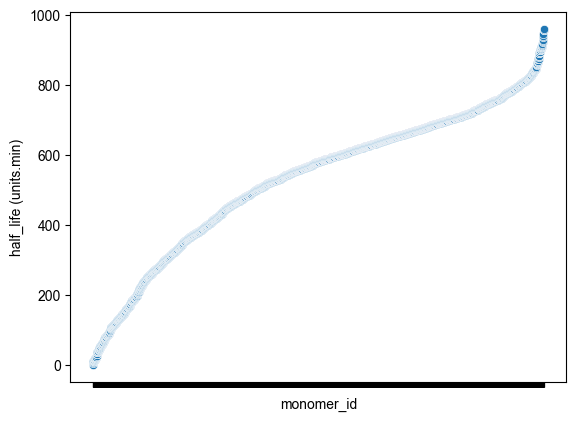

In [440]:
ax = sns.scatterplot(x='monomer_id', y='half_life (units.min)',
                     data= final_df.sort_values(by='half_life (units.min)'))

# Set the y-axis labels to an empty list
ax.set_xticklabels([])

plt.show()

/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 36.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 46.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/noravivancogonzalez/.pyenv/versions/3.11.3/envs/wcEcoli3-11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 47.1% of the points cannot be p

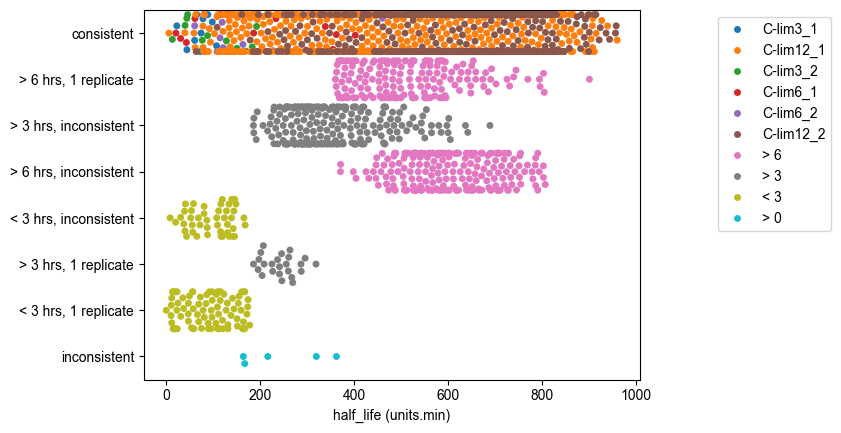

In [441]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=final_df, 
                   x= 'half_life (units.min)', y= 'notes', hue= 'assignment')
ax.set(ylabel="");
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1));